<font size="+3"><strong>8.5 Volatility Forecasting in South Africa 🇿🇦</strong></font>

In this assignment you'll build a model to predict stock volatility for the telecommunications company [MTN Group](https://www.mtn.co.za/home/).

<div class="alert alert-info" role="alert">
    <p><b>Tip:</b> There are some tasks in this assignment that you can complete by importing functions and classes you created for your app. Give it a try!</p>
</div>

<div class="alert alert-block alert-warning">
<p><b>Warning:</b> There are some tasks in this assignment where there is an extra code block that will transform your work into a <code>submission</code> that's compatible with the grader. Be sure to run those cells and inspect the <code>submission</code> before you submit to the grader.</p> 
</div>

In [1]:
%load_ext autoreload
%autoreload 2

import wqet_grader
from arch.univariate.base import ARCHModelResult

wqet_grader.init("Project 8 Assessment")


In [52]:
# Import your libraries here
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
import sqlite3
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import joblib
import pandas as pd
import requests
from config import settings
from data import SQLRepository
from arch import arch_model

# Working with APIs

**Task 8.5.1:** Create a URL to get **all** the stock data for MTN Group (`"MTNOY"`) from AlphaVantage in JSON format. Be sure to use the `https://learn-api.wqu.edu` hostname. And don't worry: your submission won't include your API key!

In [6]:
ticker = "MTNOY"
output_size = "full"
data_type = "json"

url = ("https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?"
        "function=TIME_SERIES_DAILY&"
       f"symbol={ticker}&"
       f"outputsize={output_size}&"
       f"datatype={data_type}&"
       f"apikey={settings.alpha_api_key}"
      )

print("url type:", type(url))
url

url type: <class 'str'>


'https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?function=TIME_SERIES_DAILY&symbol=MTNOY&outputsize=full&datatype=json&apikey=bc7c06013092e233773ba813df07ba10f527d0b52eb8ba63227041a146d63adf9dbb860a96365c7bf39ddee54da6527ed6827d47f6fbcab27224a17c6c75e5d296a88c8503cff74880c7fffa3e4708140931bfe4a33f210559a67c223904d0147e667c19ffd89727edf36c6bbc8b1652da6430171bc14aa6518d0325f7b04726'

In [7]:
# Remove API key for submission
submission_851 = url[:139]
submission_851

'https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?function=TIME_SERIES_DAILY&symbol=MTNOY&outputsize=full&datatype=json&apikey='

In [8]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.1", submission_851)

**Task 8.5.2:** Create an HTTP request for the URL you created in the previous task. The grader will evaluate your work by looking at the ticker symbol in the `"Meta Data"` key-value pair in your response.

In [9]:
response = requests.get(url)

print("response type:", type(response))

response type: <class 'requests.models.Response'>


In [10]:
# Get symbol in `"Meta Data"`
submission_852 = response.json()["Meta Data"]["2. Symbol"]
submission_852

'MTNOY'

In [11]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.2", submission_852)

**Task 8.5.3:** Get status code of your `response` and assign it to the variable `response_code`.

In [12]:
response_code = response.status_code

print("code type:", type(response_code))
response_code

code type: <class 'int'>


200

In [13]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.3", response_code)

# Test-Driven Development

**Task 8.5.4:** Create a DataFrame `df_mtnoy` with all the stock data for MTN. Make sure that the DataFrame has the correct type of index and column names. The grader will evaluate your work by looking at the row in `df_mtnoy` for 6 December 2021.

In [14]:
from data import AlphaVantageAPI
av = AlphaVantageAPI()
ticker = "MTNOY"
df_mtnoy = av.get_daily(ticker=ticker)

print("df_mtnoy type:", type(df_mtnoy))
df_mtnoy.head()

df_mtnoy type: <class 'pandas.core.frame.DataFrame'>


,open,high,low,close,volume
date,,,,,
2022-12-15,7.170,7.200,7.025,7.058,28846.0
2022-12-14,7.830,8.100,7.540,7.790,90111.0
2022-12-13,7.531,7.770,7.530,7.670,20956.0
2022-12-12,7.410,7.500,7.410,7.470,9192.0
2022-12-09,7.550,7.615,7.500,7.500,14393.0


In [15]:
# Get row for 6 Dec 2021
submission_854 = df_mtnoy.loc["2021-12-06"].to_frame().T
submission_854

,open,high,low,close,volume
2021-12-06,10.16,10.18,10.11,10.11,13542.0


In [16]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.4", submission_854)


**Task 8.5.5:** Connect to the database whose name is stored in the `.env` file for this project. Be sure to set the `check_same_thread` argument to `False`. Assign the connection to the variable `connection`. The grader will evaluate your work by looking at the database location assigned to `connection`.

In [17]:
connection = sqlite3.connect(database=settings.db_name,check_same_thread=False)
connection

In [18]:
# Get location of database for `connection`
submission_855 = connection.cursor().execute("PRAGMA database_list;").fetchall()[0][-1]
submission_855

'/home/jovyan/work/ds-curriculum/080-volatility-forecasting-in-india/stocks.sqlite'

In [19]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.5", submission_855)

**Task 8.5.6:** Insert `df_mtnoy` into your database. The grader will evaluate your work by looking at the first five rows of the `MTNOY` table in the database.

In [21]:
from data import SQLRepository
repo = SQLRepository(connection=connection)

In [22]:
# Insert `MTNOY` data into database
response = repo.insert_table(table_name=ticker, records=df_mtnoy, if_exists="replace")

In [23]:
# Get first five rows of `MTNOY` table
submission_856 = pd.read_sql(sql="SELECT * FROM MTNOY LIMIT 5", con=connection)
submission_856

,date,open,high,low,close,volume
0,2022-12-15 00:00:00,7.170,7.200,7.025,7.058,28846.0
1,2022-12-14 00:00:00,7.830,8.100,7.540,7.790,90111.0
2,2022-12-13 00:00:00,7.531,7.770,7.530,7.670,20956.0
3,2022-12-12 00:00:00,7.410,7.500,7.410,7.470,9192.0
4,2022-12-09 00:00:00,7.550,7.615,7.500,7.500,14393.0


In [24]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.6", submission_856)


**Task 8.5.7:** Read the `MTNOY` table from your database and assign the output to `df_mtnoy_read`. The grader will evaluate your work by looking at the row for 27 April 2022.

In [25]:
sql = "SELECT * FROM 'MTNOY'"
df_mtnoy_read = pd.read_sql(
sql=sql,con=connection,parse_dates=["date"],index_col="date"
)
print("df_mtnoy_read type:", type(df_mtnoy_read))
print("df_mtnoy_read shape:", df_mtnoy_read.shape)
df_mtnoy_read.head()

df_mtnoy_read type: <class 'pandas.core.frame.DataFrame'>
df_mtnoy_read shape: (3886, 5)


,open,high,low,close,volume
date,,,,,
2022-12-15,7.170,7.200,7.025,7.058,28846.0
2022-12-14,7.830,8.100,7.540,7.790,90111.0
2022-12-13,7.531,7.770,7.530,7.670,20956.0
2022-12-12,7.410,7.500,7.410,7.470,9192.0
2022-12-09,7.550,7.615,7.500,7.500,14393.0


In [26]:
# Get row for 27 April 2022
submission_857 = df_mtnoy_read.loc["2022-04-27"].to_frame().T
submission_857

,open,high,low,close,volume
2022-04-27,10.71,10.85,10.5,10.65,23927.0


In [27]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.7", submission_857)


# Predicting Volatility

## Prepare Data

**Task 8.5.8:** Create a Series `y_mtnoy` with the 2,500 most recent returns for MTN. The grader will evaluate your work by looking at the volatility for 9 August 2022.

In [28]:
def wrangle_data(ticker,n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df = repo.read_table(table_name=ticker,limit=n_observations+1)

    # Sort DataFrame ascending by date
    df.sort_index(ascending=True,inplace=True)

    # Create "return" column
    df["return"]=df["close"].pct_change()*100

    # Return returns
    return df["return"].dropna()

In [29]:

y_mtnoy = wrangle_data(ticker="MTNOY", n_observations=2500)

print("y_mtnoy type:", type(y_mtnoy))
print("y_mtnoy shape:", y_mtnoy.shape)
y_mtnoy.head()

y_mtnoy type: <class 'pandas.core.series.Series'>
y_mtnoy shape: (2500,)


date
2013-01-14    0.295276
2013-01-15   -2.796860
2013-01-16    1.463907
2013-01-17    0.248756
2013-01-18   -0.739454
Name: return, dtype: float64

In [30]:
# Get data for 8 Aug 2022
submission_859 = float(y_mtnoy["2022-08-09"])
submission_859

1.5783540022547893

In [31]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.8", submission_859)

**Task 8.5.9:** Calculate daily volatility for `y_mtnoy`, and assign the result to `mtnoy_daily_volatility`.

In [32]:
mtnoy_daily_volatility = y_mtnoy.std()

print("mtnoy_daily_volatility type:", type(mtnoy_daily_volatility))
print("MTN Daily Volatility:", mtnoy_daily_volatility)

mtnoy_daily_volatility type: <class 'float'>
MTN Daily Volatility: 2.9150959859115475


In [33]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.9", mtnoy_daily_volatility)

**Task 8.5.10:** Calculate the annual volatility for `y_mtnoy`, and assign the result to `mtnoy_annual_volatility`.

In [36]:
mtnoy_annual_volatility = mtnoy_daily_volatility*(252)**0.5

print("mtnoy_annual_volatility type:", type(mtnoy_annual_volatility))
print("MTN Annual Volatility:", mtnoy_annual_volatility)

mtnoy_annual_volatility type: <class 'float'>
MTN Annual Volatility: 46.27571415962761


In [37]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.10", float(mtnoy_annual_volatility))

**Task 8.5.11:** Create a time series line plot for `y_mtnoy`. Be sure to label the x-axis `"Date"`, the y-axis `"Returns"`, and use the title `"Time Series of MTNOY Returns"`.

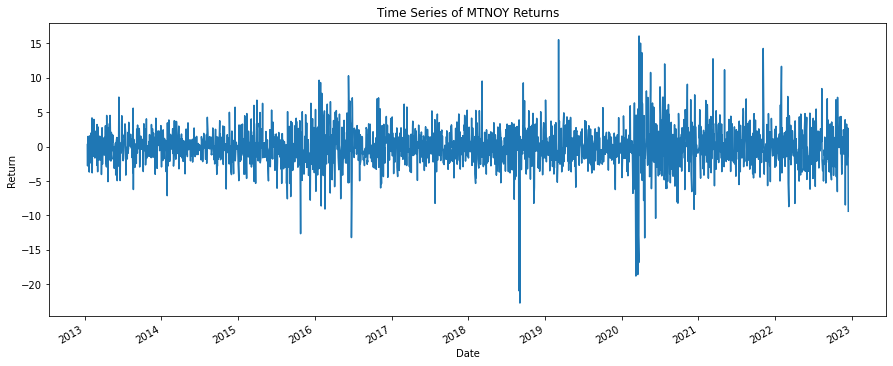

In [40]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_mtnoy` on `ax`
y_mtnoy.plot(ax=ax, label="MTNOY")

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Return")

# Add title
plt.title("Time Series of MTNOY Returns")

# Don't delete the code below 👇
plt.savefig("images/8-5-11.png", dpi=150)


In [41]:
with open("images/8-5-11.png", "rb") as file:
    wqet_grader.grade("Project 8 Assessment", "Task 8.5.11", file)

**Task 8.5.12:** Create an ACF plot of the squared returns for MTN. Be sure to label the x-axis `"Lag [days]"`, the y-axis `"Correlation Coefficient"`, and use the title `"ACF of MTNOY Squared Returns"`.

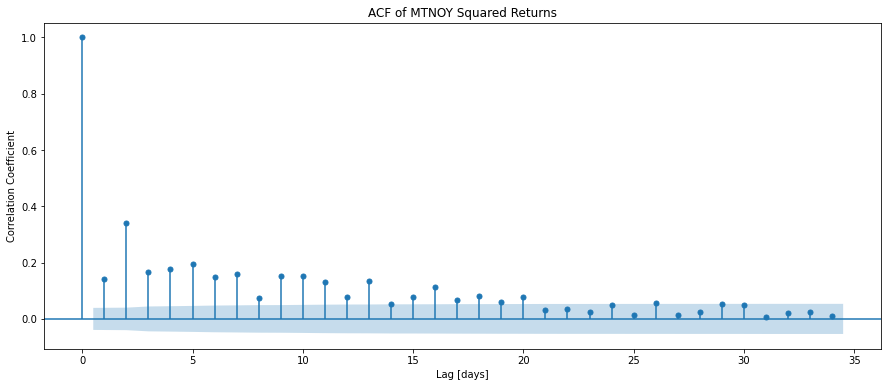

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_mtnoy**2,ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

# Add title
plt.title("ACF of MTNOY Squared Returns")

# Don't delete the code below 👇
plt.savefig("images/8-5-12.png", dpi=150)


In [45]:
with open("images/8-5-12.png", "rb") as file:
    wqet_grader.grade("Project 8 Assessment", "Task 8.5.12", file)

**Task 8.5.13:** Create a PACF plot of the squared returns for MTN. Be sure to label the x-axis `"Lag [days]"`, the y-axis `"Correlation Coefficient"`, and use the title `"PACF of MTNOY Squared Returns"`.

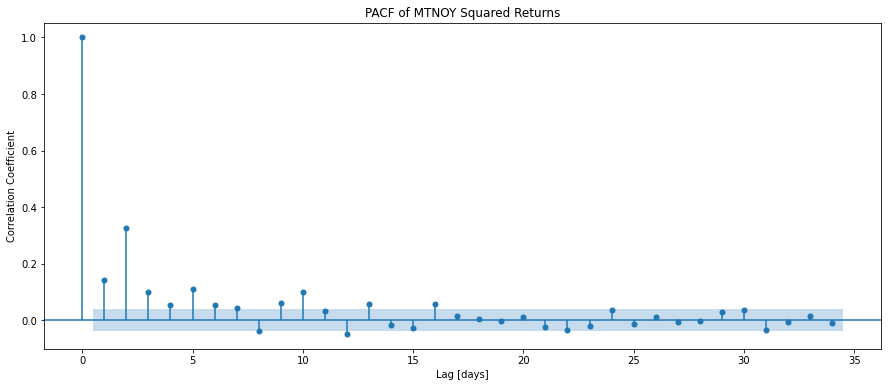

In [46]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_pacf(y_mtnoy**2,ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

# Add title
plt.title("PACF of MTNOY Squared Returns")


# Don't delete the code below 👇
plt.savefig("images/8-5-13.png", dpi=150)


In [47]:
with open("images/8-5-13.png", "rb") as file:
    wqet_grader.grade("Project 8 Assessment", "Task 8.5.13", file)

**Task 8.5.14:** Create a training set `y_mtnoy_train` that contains the first 80% of the observations in `y_mtnoy`. 

In [49]:
cutoff_test =  int(len(y_mtnoy)*0.8)
y_mtnoy_train = y_mtnoy.iloc[:cutoff_test]

print("y_mtnoy_train type:", type(y_mtnoy_train))
print("y_mtnoy_train shape:", y_mtnoy_train.shape)
y_mtnoy_train.head()

y_mtnoy_train type: <class 'pandas.core.series.Series'>
y_mtnoy_train shape: (2000,)


date
2013-01-14    0.295276
2013-01-15   -2.796860
2013-01-16    1.463907
2013-01-17    0.248756
2013-01-18   -0.739454
Name: return, dtype: float64

In [50]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.14", y_mtnoy_train)

## Build Model

**Task 8.5.15:** Build and fit a GARCH model using the data in `y_mtnoy`. Try different values for `p` and `q`, using the summary to assess its performance. The grader will evaluate whether your `model` is the correct data type.

In [53]:
# Build and train model
model = arch_model(
y_mtnoy_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)

print("model type:", type(model))

# Show model summary


model type: <class 'arch.univariate.base.ARCHModelResult'>


In [54]:
submission_8515 = isinstance(model, ARCHModelResult)
submission_8515

True

In [55]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.15", [submission_8515])

**Task 8.5.16:** Plot the standardized residuals for your `model`. Be sure to label the x-axis `"Date"`, the y-axis `"Value"`, and use the title `"MTNOY GARCH Model Standardized Residuals"`.

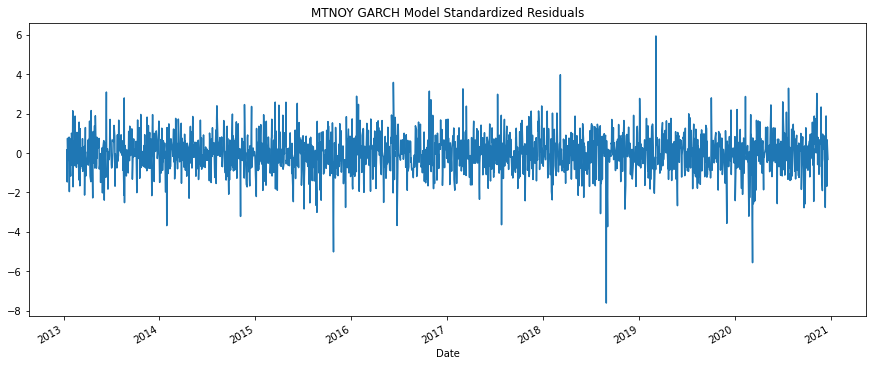

In [56]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax,label="Standardized Residuals")

# Add axis labels
plt.xlabel("Date")

# Add title
plt.title("MTNOY GARCH Model Standardized Residuals")

# Don't delete the code below 👇
plt.savefig("images/8-5-16.png", dpi=150)


In [57]:
with open("images/8-5-16.png", "rb") as file:
    wqet_grader.grade("Project 8 Assessment", "Task 8.5.16", file)

**Task 8.5.17:** Create an ACF plot of the squared, standardized residuals of your `model`. Be sure to label the x-axis `"Lag [days]"`, the y-axis `"Correlation Coefficient"`, and use the title `"ACF of MTNOY GARCH Model Standardized Residuals"`.

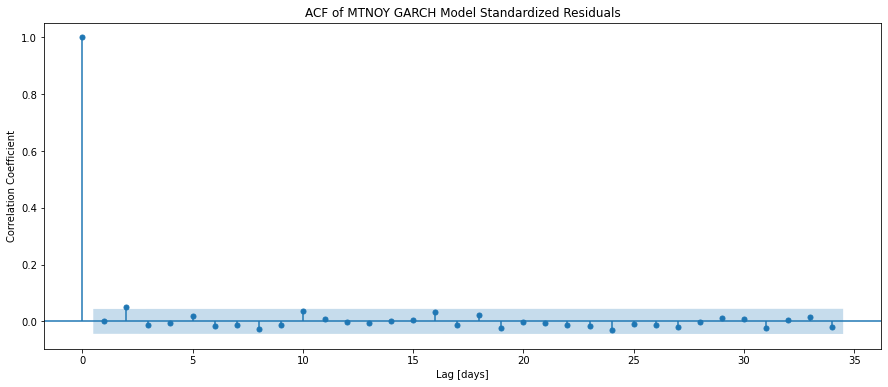

In [58]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2,ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

# Add title
plt.title("ACF of MTNOY GARCH Model Standardized Residuals")

# Don't delete the code below 👇
plt.savefig("images/8-5-17.png", dpi=150)


In [59]:
with open("images/8-5-17.png", "rb") as file:
    wqet_grader.grade("Project 8 Assessment", "Task 8.5.17", file)

# Model Deployment

**Ungraded Task:** If it's not already running, start your app server.  

**Task 8.5.18:** Change the `fit` method of your `GarchModel` class so that, when a model is done training, two more attributes are added to the object: `self.aic` with the AIC for the model, and `self.bic` with the BIC for the model. When you're done, use the cell below to check your work.

<div class="alert alert-info" role="alert">
    <p><b>Tip:</b> How can you access the AIC and BIC scores programmatically? Every <code>ARCHModelResult</code> has an <code>.aic</code> and a <code>.bic</code> attribute.</p>
</div>

In [61]:
# Import `build_model` function
from main import build_model

# Build model using new `MTNOY` data
model = build_model(ticker="MTNOY", use_new_data=True)

# Wrangle `MTNOY` returns
model.wrangle_data(n_observations=2500)

# Fit GARCH(1,1) model to data
model.fit(p=1, q=1)

# Does model have AIC and BIC attributes?
assert hasattr(model, "aic")
assert hasattr(model, "bic")

In [62]:
# Put test results into dictionary
submission_8518 = {"has_aic": hasattr(model, "aic"), "has_bic": hasattr(model, "bic")}
submission_8518

{'has_aic': True, 'has_bic': True}

In [63]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.18", submission_8518)

**Task 8.5.19:** Change the `fit_model` function in the `main` module so that the `"message"` it returns includes the AIC and BIC scores. For example, the message should look something like this:

```
"Trained and saved 'models/2022-10-12T23:10:06.577238_MTNOY.pkl'. Metrics: AIC 9892.184665169907, BIC 9914.588275008075."
```


When you're done, use the cell below to check your work.

In [65]:
# Import `FitIn` class and `fit_model` function
from main import FitIn, fit_model

# Instantiate `FitIn` object
request = FitIn(ticker="MTNOY", use_new_data=False, n_observations=2500, p=1, q=1)

# Build model and fit to data, following parameters in `request`
fit_out = fit_model(request=request)

# Inspect `fit_out`
fit_out

{'ticker': 'MTNOY',
 'use_new_data': False,
 'n_observations': 2500,
 'p': 1,
 'q': 1,
 'success': True,
 'message': "Trained and saved 'models/2022-12-16T18:21:29.719132_MTNOY.pkl'. Metrics: AIC 12003.02429592052, BIC 12026.320479963946"}

In [66]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.19", fit_out)

**Task 8.5.20:** Create a `post` request to hit the `"/fit"` path running at `"http://localhost:8008"`. You should train a GARCH(1,1) model on 2500 observations of the MTN data you already downloaded. Pass in your parameters as a dictionary using the `json` argument. The grader will evaluate the JSON of your `response`.

In [67]:
# URL of `/fit` path
url = "http://localhost:8008/fit"
# Data to send to path
json = {
    "ticker":"MTN",
    "use_new_data":True,
    "n_observations": 2500,
    "p":1,
    "q":1
}
# Response of post request
response = requests.post(url=url,json=json)

print("response type:", type(response))
print("response status code:", response.status_code)

response type: <class 'requests.models.Response'>
response status code: 200


In [68]:
submission_8520 = response.json()
submission_8520

{'ticker': 'MTN',
 'use_new_data': True,
 'n_observations': 2500,
 'p': 1,
 'q': 1,
 'success': True,
 'message': "Trained and saved 'models/2022-12-16T18:22:50.865357_MTN.pkl'. Metrics: AIC 9741.064212405683, BIC 9764.360396449109"}

In [69]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.20", submission_8520)

Exception: Could not grade submission: Could not verify access to this assessment: Received error from WQET submission API: Could not find existing program enrollment for user

**Task 8.5.21:** Create a `post` request to hit the `"/predict"` path running at `"http://localhost:8008"`. You should get the 5-day volatility forecast for MTN. When you're satisfied, submit your work to the grader.

In [70]:
# URL of `/predict` path
url =  "http://localhost:8008/predict"
# Data to send to path
json = {
    "ticker":"MTN",
    "n_days":5
    
}
# Response of post request
response = requests.post(url=url,json=json)

print("response type:", type(response))
print("response status code:", response.status_code)

response type: <class 'requests.models.Response'>
response status code: 200


In [74]:
pip install dropbox

     |████████████████████████████████| 594 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 162 kB 115.7 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 10.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [75]:
import pathlib
import dropbox
import re
import os
def getListOfFiles(dirName):

    listOfFile = os.listdir(dirName)
    allFiles = list()
   
    for entry in listOfFile:
        
        fullPath = os.path.join(dirName, entry)
        
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

directory="/home/jovyan/work/ds-curriculum/080-volatility-forecasting-in-india"
listOfFiles = getListOfFiles(directory)
for (dirpath, dirnames, filenames) in os.walk(directory):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
total=len(listOfFiles)
i=0
for elem in listOfFiles:
        
    filepath= os.path.join(directory,elem)
    i=i+1

    folder = pathlib.Path(".")   
    filename = filepath         
    print("Progress: "+str(round((float(i)/float(total))*100,2))+"% - "+filename, end='\r')
    filepath = folder / filename  

   
    target = "/WQUFolder"             
    targetfile = target + filename   

   
    d = dropbox.Dropbox('sl.BVHnaE4PEjllTdXKbHFoZ_EcbRbkZEcFjffC1o6fl01jTB0U7pxgvMCnCzc8Nt9CojJvJST9gxuUZnyFH3udAa6j71guaf3YTYbzyurgHIqLKLQ7IEA0vxt8jCklQSt3W-0C9ok')

    
    with filepath.open("rb") as f:

       meta = d.files_upload(f.read(), targetfile, mode=dropbox.files.WriteMode("overwrite"))

print("Done!")


AuthError: AuthError('474864221c754b0ea0816cb21c699500', AuthError('invalid_access_token', None))

In [71]:
submission_8521 = response.json()
submission_8521

{'ticker': 'MTN',
 'n_days': 5,
 'success': True,
 'forecast': {'2022-12-16T00:00:00': 2.0420007174027135,
  '2022-12-19T00:00:00': 2.0378698767733323,
  '2022-12-20T00:00:00': 2.0338326141927747,
  '2022-12-21T00:00:00': 2.0298869737374248,
  '2022-12-22T00:00:00': 2.026031033633013},
 'message': ''}

In [72]:
wqet_grader.grade("Project 8 Assessment", "Task 8.5.21", submission_8521)

Exception: Could not grade submission: Could not verify access to this assessment: Received error from WQET submission API: Could not find existing program enrollment for user

---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
